In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [4]:
df = pd.read_csv('feature_data.csv')

# CNN

In [7]:
# 🔹 Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["filename"]
        label = self.df.iloc[idx]["label"]
        
        # Load image in grayscale and convert to 3-channel
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))  # Resize to standard shape
        image = np.stack([image]*3, axis=-1)  # Convert to 3 channels
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# 🔹 Image Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

# 🔹 Split Data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# 🔹 Create Data Loaders
train_dataset = ImageDataset(train_df, img_dir="data", transform=transform)
test_dataset = ImageDataset(test_df, img_dir="data", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔹 Define CNN Model
class CNNBinaryClassifier(nn.Module):
    def __init__(self):
        super(CNNBinaryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + Pool
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # No sigmoid here
        return x

# 🔹 Initialize Model
model = CNNBinaryClassifier()

# 🔹 Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Stable for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/50], Loss: 0.6762
Epoch [2/50], Loss: 0.5727
Epoch [3/50], Loss: 0.4547
Epoch [4/50], Loss: 0.4966
Epoch [5/50], Loss: 0.4533
Epoch [6/50], Loss: 0.4199
Epoch [7/50], Loss: 0.3758
Epoch [8/50], Loss: 0.3673
Epoch [9/50], Loss: 0.3590
Epoch [10/50], Loss: 0.3282
Epoch [11/50], Loss: 0.3163
Epoch [12/50], Loss: 0.2919
Epoch [13/50], Loss: 0.2628
Epoch [14/50], Loss: 0.2408
Epoch [15/50], Loss: 0.2095
Epoch [16/50], Loss: 0.1974
Epoch [17/50], Loss: 0.1544
Epoch [18/50], Loss: 0.1266
Epoch [19/50], Loss: 0.0816
Epoch [20/50], Loss: 0.0637
Epoch [21/50], Loss: 0.0630
Epoch [22/50], Loss: 0.0406
Epoch [23/50], Loss: 0.0240
Epoch [24/50], Loss: 0.0177
Epoch [25/50], Loss: 0.0119
Epoch [26/50], Loss: 0.0103
Epoch [27/50], Loss: 0.0087
Epoch [28/50], Loss: 0.0070
Epoch [29/50], Loss: 0.0047
Epoch [30/50], Loss: 0.0039
Epoch [31/50], Loss: 0.0032
Epoch [32/50], Loss: 0.0028
Epoch [33/50], Loss: 0.0024
Epoch [34/50], Loss: 0.0020
Epoch [35/50], Loss: 0.0018
Epoch [36/50], Loss: 0.0016
E

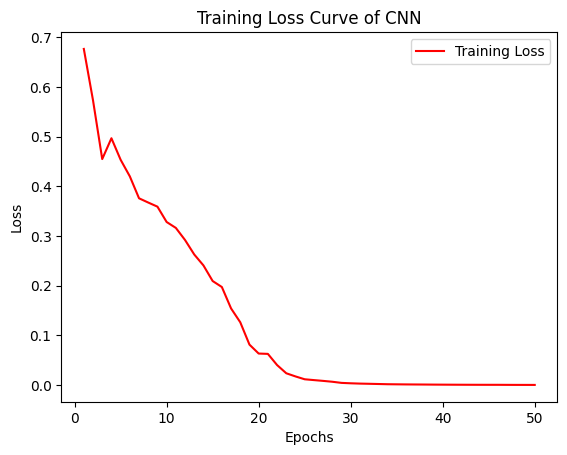

In [8]:
# 🔹 Training Loop
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []  # List to store loss values

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)  # Ensure (N,1) shape
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)  # Store loss per epoch
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# 🔹 Plot Training Loss Curve
plt.plot(range(1, epochs + 1), train_losses, color="r", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve of CNN")
plt.legend()
plt.show()

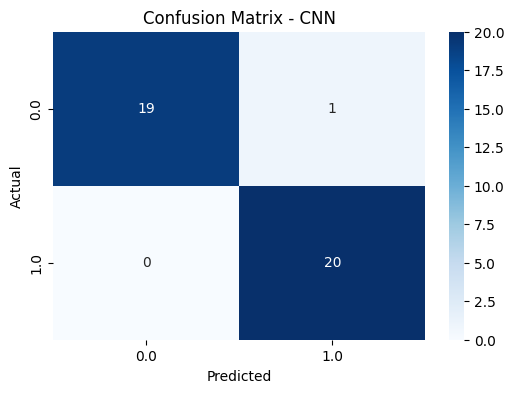

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [10]:
# 🔹 Evaluate Model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        
        y_true.extend(labels.cpu().numpy().tolist())  # Convert to list
        y_pred.extend(predictions.cpu().numpy().tolist())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 🔹 Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()

# 🔹 Print Classification Report
print(classification_report(y_true, y_pred))

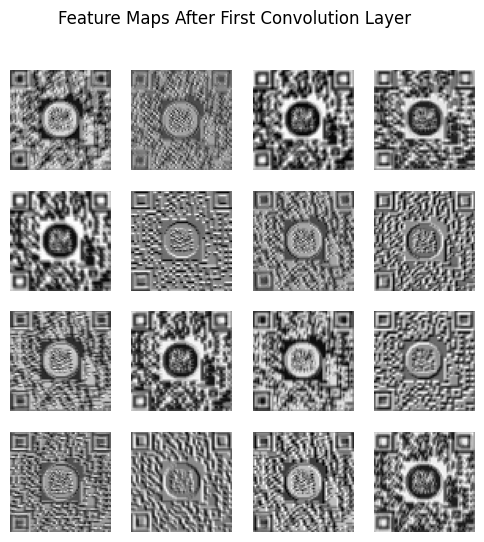

In [11]:
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0)  # Add batch dimension
    activations = []

    # Hook function to capture outputs
    def hook_fn(module, input, output):
        activations.append(output)

    # Attach hook to first conv layer
    hook = model.conv1.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(image.to(device))

    hook.remove()

    # Plot feature maps
    feature_maps = activations[0].cpu().squeeze(0)  # Remove batch dim
    fig, axs = plt.subplots(4, 4, figsize=(6, 6))  # Assuming 16 feature maps

    for i, ax in enumerate(axs.flat):
        if i < feature_maps.shape[0]:
            ax.imshow(feature_maps[i], cmap="gray")
            ax.axis("off")

    plt.suptitle("Feature Maps After First Convolution Layer")
    plt.show()

# 🔹 Test on a sample image
sample_image, _ = test_dataset[2]  # Get first image from test dataset
visualize_feature_maps(model, sample_image)


Total Misclassified Images: 1


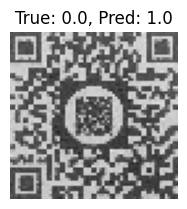

In [12]:
import matplotlib.pyplot as plt

# 🔹 Evaluate Model and Find Misclassified Images
model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        
        for i in range(len(labels)):
            if predictions[i] != labels[i]:  # Misclassified case
                misclassified_images.append(images[i].cpu())  # Store image
                misclassified_labels.append(labels[i].cpu().item())  # Store actual label
                misclassified_preds.append(predictions[i].cpu().item())  # Store predicted label

# 🔹 Display Misclassified Images
num_misclassified = len(misclassified_images)
print(f"Total Misclassified Images: {num_misclassified}")

if num_misclassified > 0:
    plt.figure(figsize=(10, 10))
    for i in range(min(16, num_misclassified)):  # Show up to 16 images
        img = misclassified_images[i].permute(1, 2, 0).numpy()  # Convert Tensor to NumPy
        img = (img * 0.5) + 0.5  # De-normalize
        
        plt.subplot(4, 4, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
        plt.axis("off")
    
    plt.show()
